In [1]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
!pip install openpyxl

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU
df = pd.read_excel("north_india_agg_27march.xlsx")
df.dropna(subset=['Date'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

full_dates = pd.DataFrame({'Date': pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')})
df = full_dates.merge(df, on='Date', how='left')
df.set_index('Date', inplace=True)

df.replace(0, np.nan, inplace=True)
df = df.interpolate(method="polynomial", order=2, limit_direction="both")
df = df.interpolate(method="linear", limit_direction="both")

for col in df.columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.columns:
    if (df[col] < 0).any():
        smooth_mean = df.loc[df[col] > 0, col].mean()
        df[col] = df[col].apply(lambda x: x if x > 0 else smooth_mean)

scaler=RobustScaler()
scaled_values=scaler.fit_transform(df)
def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)
lag = 45
X, y = create_lagged_dataset(scaled_values, lag)
split=int(len(X)*0.80)
X_train,X_test=X[:split],X[split:]
y_train,y_test=y[:split],y[split:]
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_ann.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
model.fit(X_train, y_train, epochs=550, batch_size=5,callbacks=[early_stop, model_checkpoint], verbose=1)

y_pred=model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
y_pred_inv=scaler.inverse_transform(y_pred)
y_test_inv=scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test_inv,y_pred_inv)
mse = mean_squared_error(y_test_inv,y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Epoch 1/550


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 107328405332889174016.0000
Epoch 2/550
 5/62 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 193246432.0000

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 88086125014065086464.0000
Epoch 3/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 42970528496555655168.0000
Epoch 4/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 33694533833195520000.0000
Epoch 5/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 863817007914960289792.0000
Epoch 6/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 2386393266248935800832.0000
Epoch 7/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 308683157200066052096.0000
Epoch 8/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 389786829223893139456.0000
Epoch 9/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 267007585120193347584.0000
Epoch 10/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 253784787915814993920.0000
Epoch 11/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 441845872457133588480.0000
Epoch 12/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1631931679323367407616.0000
Epoch 13/550
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU
import pickle

In [3]:

df = pd.read_excel("north_india_agg_27march.xlsx")
df.dropna(subset=['Date'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

full_dates = pd.DataFrame({'Date': pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')})
df = full_dates.merge(df, on='Date', how='left')
df.set_index('Date', inplace=True)

df.replace(0, np.nan, inplace=True)
df = df.interpolate(method="polynomial", order=2, limit_direction="both")
df = df.interpolate(method="linear", limit_direction="both")

for col in df.columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.columns:
    if (df[col] < 0).any():
        smooth_mean = df.loc[df[col] > 0, col].mean()
        df[col] = df[col].apply(lambda x: x if x > 0 else smooth_mean)

scaler=RobustScaler()
scaled_values=scaler.fit_transform(df)
def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)
lag = 45
X, y = create_lagged_dataset(scaled_values, lag)
split=int(len(X))
X_train,X_test=X[:split],X[:split]
y_train,y_test=y[:split],y[:split]

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_ann.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
model.fit(X_train, y_train, epochs=550, batch_size=5,callbacks=[early_stop, model_checkpoint], verbose=1)

y_pred=model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
y_pred_inv=scaler.inverse_transform(y_pred)
y_test_inv=scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test_inv,y_pred_inv)
mse = mean_squared_error(y_test_inv,y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
with open('model_ann.pkl','wb') as file:
  pickle.dump(model,file)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - loss: 192648616488306999296.0000
Epoch 2/550
 1/78 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - loss: 768081133568.0000

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 660014276971423858688.0000
Epoch 3/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 326363831940285464576.0000
Epoch 4/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 399089049438598987776.0000
Epoch 5/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 262670935338384359424.0000
Epoch 6/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 336902642096425402368.0000
Epoch 7/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 587199339324283813888.0000
Epoch 8/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 111313519257065619456.0000
Epoch 9/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 234778102152497725440.0000
Epoch 10/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 235227916757467398144.0000
Epoch 11/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 778524882684562374656.0000
Epoch 12/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 273589437645920927744.0000
Epoch 13/550
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step

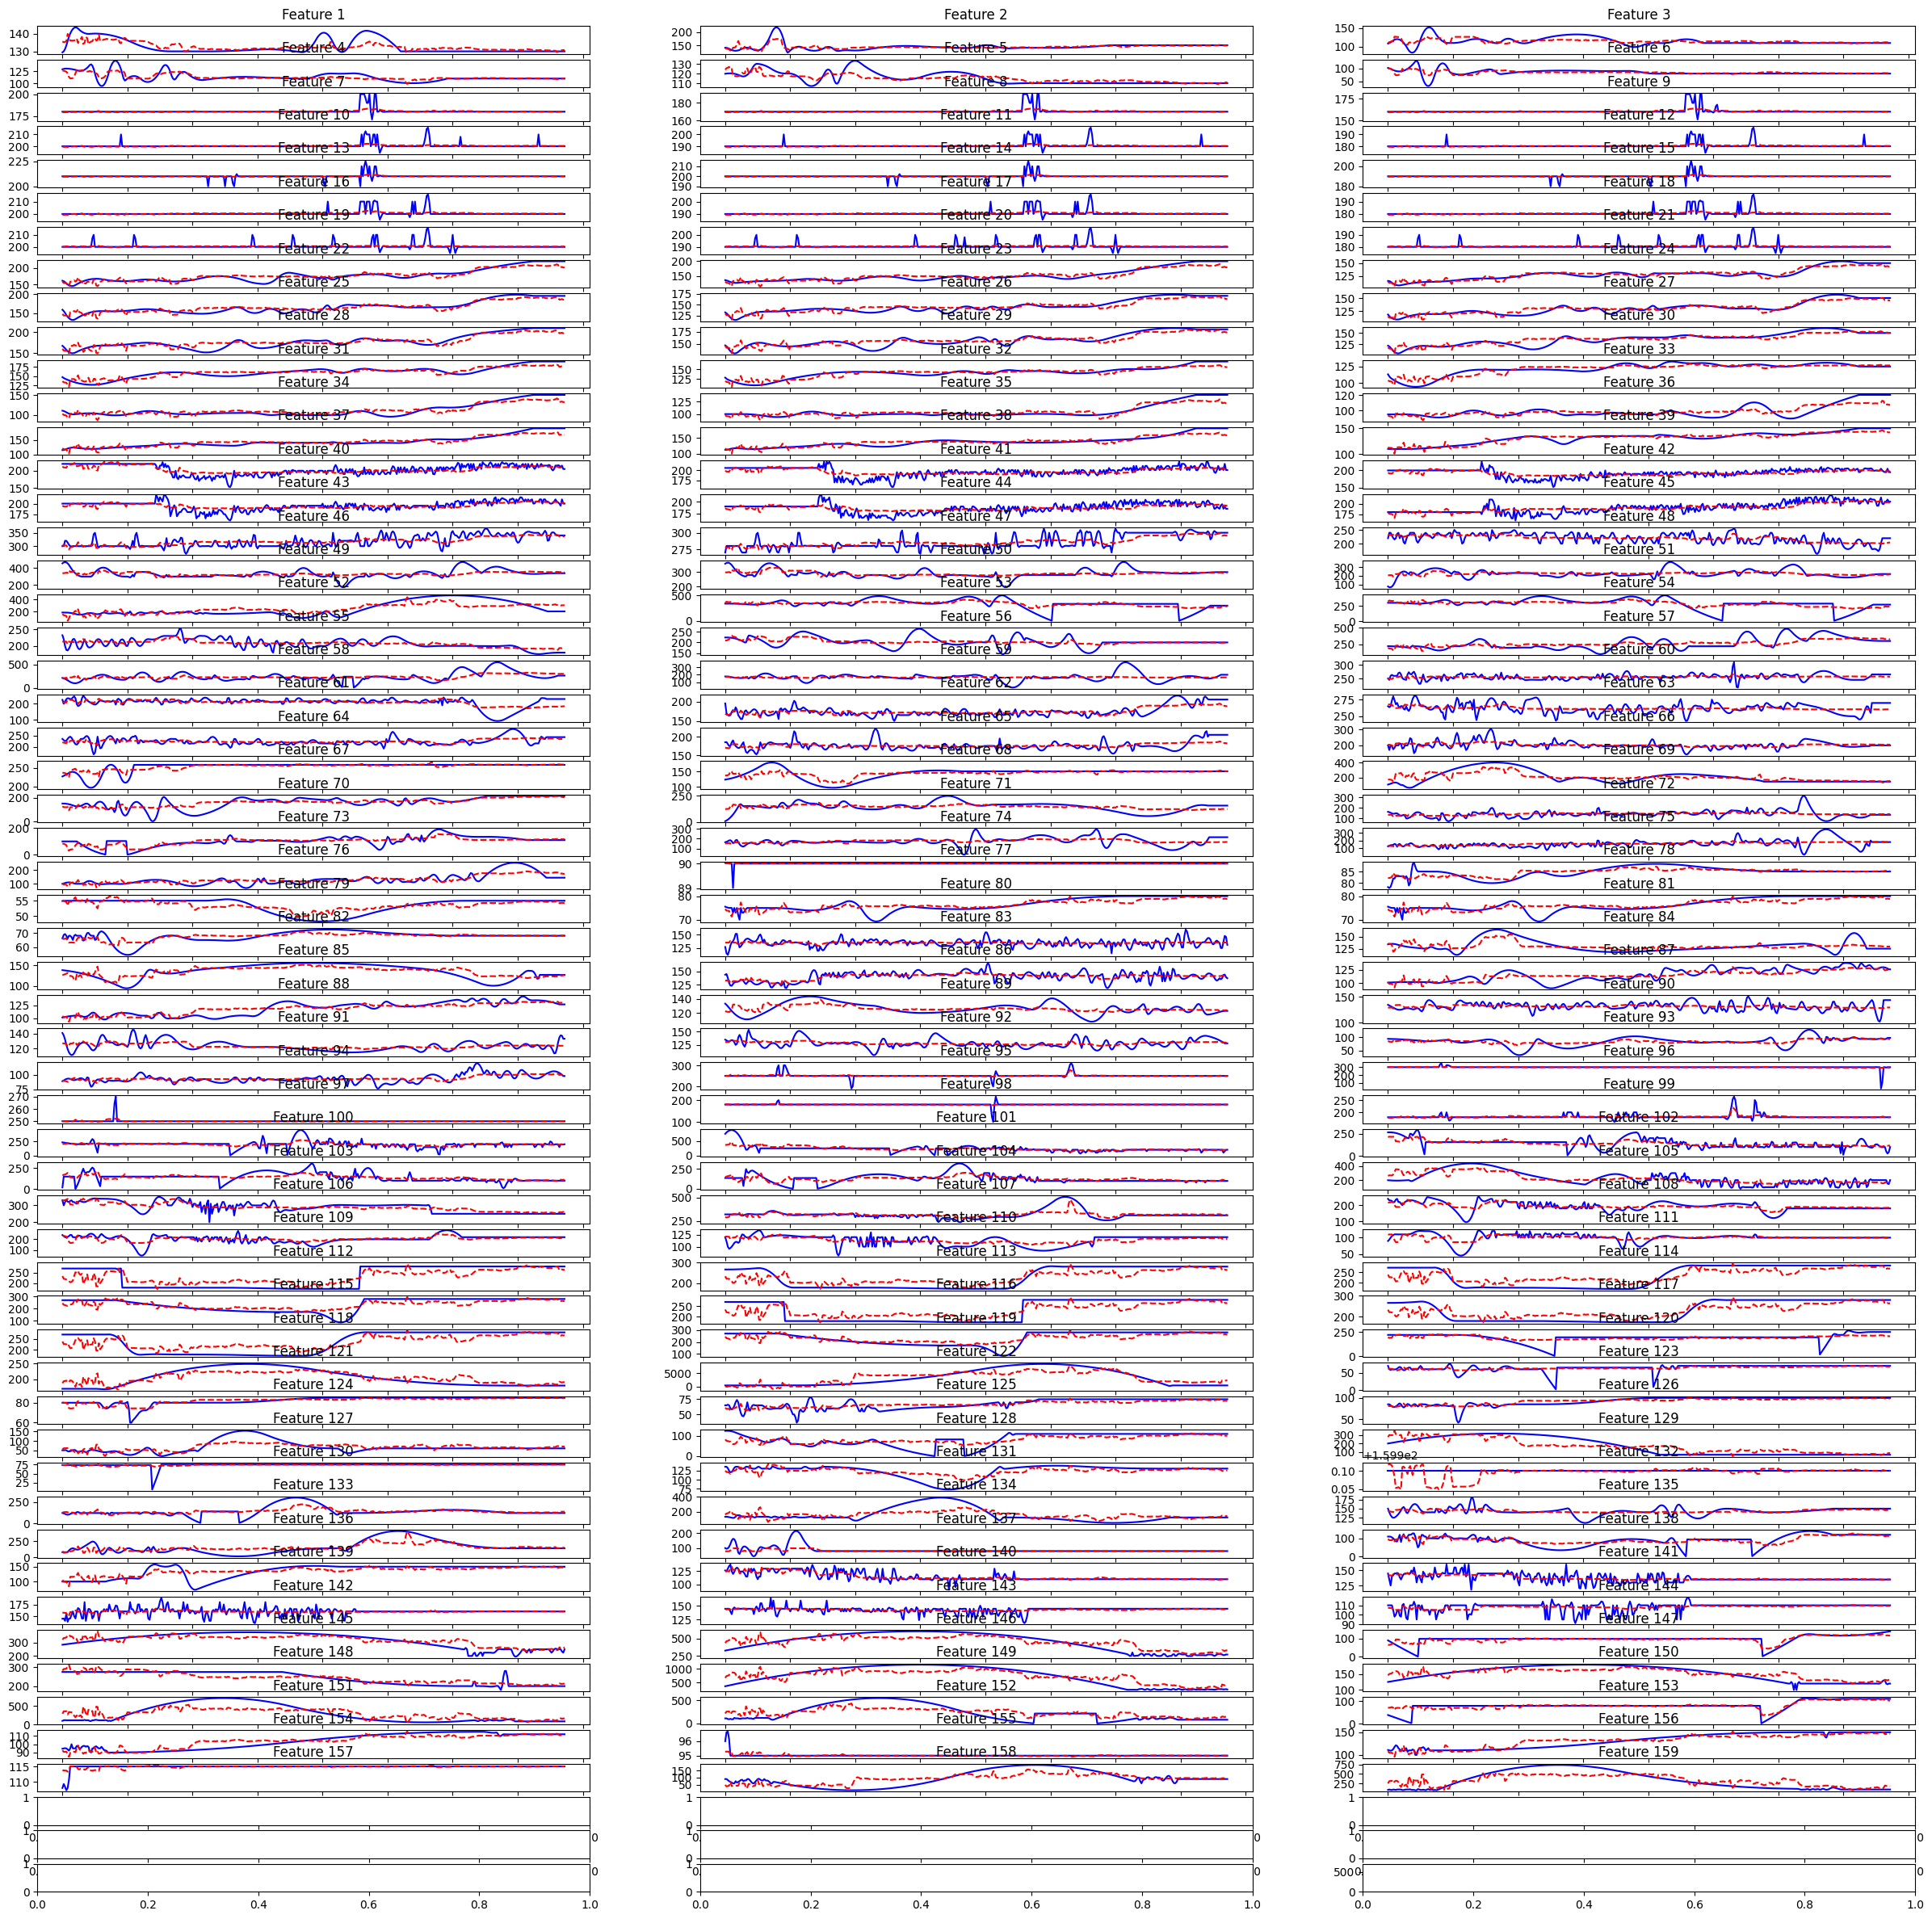

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=56, ncols=3, figsize=(30,30))
axes = axes.flatten()


for i in range(y_test_inv.shape[1]):
    axes[i].plot(y_test_inv[:, i], label=f"Actual Feature {i + 1}", color="blue")
    axes[i].plot(y_pred_inv[:, i], label=f"Predicted Feature {i + 1}", linestyle="--", color="red")

    axes[i].set_title(f"Feature {i + 1}")
    axes[i].tick_params(axis='x', rotation=45)

plt.ylim(0,700)
plt.show()



**FINAL FUNCTION**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from datetime import datetime

In [6]:
def get_fish_column(fish, size, market):

    fish_mapping = {
        "Pangas Catfish": "Pangas_Catfish",
        "Catla": "Catla",
        "Rohu": "Rohu",
        "Common Carp": "Common_Carp",
        "Grass Carp": "Grass_Carp",
        "Roopchand": "Roopchand"
    }


    size_mapping = {
        "Small": "Small",
        "Medium": "Medium",
        "Large": "Large"
    }
    market_mapping = {
        "DDA Market": "A",
        "Ghazipur Market": "B",
        "Barnala Market": "C",
        "Ludhiana Market": "D",
        "Sunam Dhuri Market": "E",
        "Amritsar Market": "F",
        "Faridabad Market": "G",
        "Yamuna Nagar Market": "H",
        # "Donar Wholesale Market":"I",
        "Macchwatoli Retail Fish Market":"J",
        "Mushallapur Wholesale Fish Market":"K",
        "Saidnagar Retail Fish Market":"L",
        "Bhakra Gobind Sagar Fish Landing Center":"M",
        "Nagrota Surian Fish Landing Center":"N",
        "Fish Retail Market Gumma Shimla":"O",
        "Jaipur Wholesale Fish Market":"P",
        "Udaipur Retail Fish Market":"Q",
        "Wholesale Market Dubagga Lucknow":"R",
        "Retail Market Mahesara Gorakhpur":"S",
        # "JK Fish Sahasthadhara Wholesale Market":"T",
        "Naveen Krishi Mandi Wholesale Fish Market":"U"
    }

    if fish in fish_mapping and size in size_mapping and market in market_mapping:
        return f"{fish_mapping[fish]}_{size_mapping[size]}_Market{market_mapping[market]}"
    else:
        return "Incorrect Input"


In [20]:
def predict(fore_date, market, fish, size):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime, timedelta
    from sklearn.preprocessing import RobustScaler
    import pickle

    train_data = pd.read_excel("north_india_agg_27march.xlsx")
    train_data.dropna(subset=['Date'], inplace=True)
    train_data['Date'] = pd.to_datetime(train_data['Date'], format='%d-%m-%Y', errors='coerce')
    full_dates = pd.DataFrame({'Date': pd.date_range(start=train_data['Date'].min(), end=train_data['Date'].max(), freq='D')})
    train_data = full_dates.merge(train_data, on='Date', how='left')
    train_data.set_index('Date', inplace=True)
    train_data.replace(0, np.nan, inplace=True)
    train_data = train_data.interpolate(method="polynomial", order=2, limit_direction="both")
    train_data = train_data.interpolate(method="linear", limit_direction="both")
    for col in train_data.columns:
        train_data[col] = train_data[col].fillna(train_data[col].median())
    for col in train_data.columns:
        if (train_data[col] < 0).any():
            smooth_mean = train_data.loc[train_data[col] > 0, col].mean()
            train_data[col] = train_data[col].apply(lambda x: x if x > 0 else smooth_mean)

    scaler = RobustScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train_data),
                                columns=train_data.columns,
                                index=train_data.index)

    baseline_date = datetime.strptime("07-03-2025", "%d-%m-%Y")
    with open('model_ann.pkl', 'rb') as file:
        model = pickle.load(file)

    if fore_date < baseline_date:
        return "enter dates after 7th March,2025 only"

    steps = (fore_date - baseline_date).days

    input_data = train_scaled.values[-45:].reshape(1, 45, -1)
    forecast_scaled = []
    for _ in range(steps):
        pred = model.predict(input_data)
        forecast_scaled.append(pred[0])
        new_input = np.concatenate([input_data[0][1:], pred], axis=0)
        input_data = new_input.reshape(1, 45, -1)

    forecast = scaler.inverse_transform(forecast_scaled)
    forecast_dates = [baseline_date + timedelta(days=i + 1) for i in range(steps)]
    forecast_data = pd.DataFrame(forecast, columns=train_data.columns, index=forecast_dates)

    fish_and_size = get_fish_column(fish, size, market)
    if fish_and_size not in forecast_data.columns:
        return "Incorrect Input"
    fish_data = forecast_data[fish_and_size]
    forecast_dates = []
    final_forecast_data = {
        'Date': [],
        'Prediction': []
    }
    print("Forecast of Fish Prices ")
    for i in range(len(fish_data)):
        current_date = baseline_date + timedelta(days=i + 1)
        print("Date {} Prediction {} Rupees".format(current_date.strftime("%d-%m-%y"), np.round(fish_data[i])))
        forecast_dates.append(current_date)
        final_forecast_data['Date'].append(current_date)
        final_forecast_data['Prediction'].append(np.round(fish_data[i]))
    plt.plot(train_data.index, train_data[fish_and_size], label="Historical Data", color="blue")
    plt.plot(forecast_dates, fish_data, label="Forecast Data", linestyle="--", color="red")
    plt.xticks(rotation=45)
    # plt.ylim(0, 1500)
    plt.legend()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

<ipython-input-20-1b22206112ba>:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Date {} Prediction {} Rupees".format(current_date.strftime("%d-%m-%y"), np.round(fish_data[i])))
<ipython-input-20-1b22206112ba>:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_forecast_data['Prediction'].append(np.round(fish_data[i]))


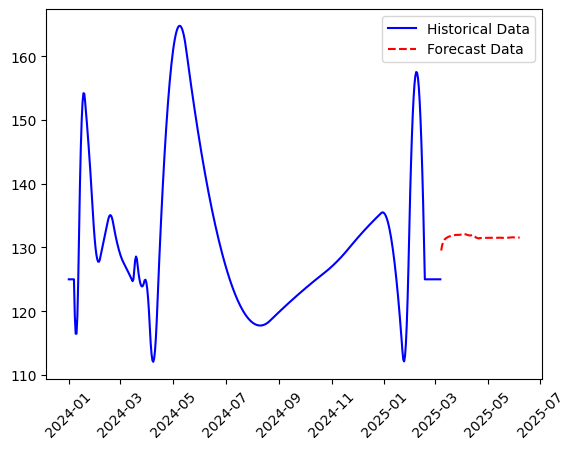

In [24]:
predict(datetime.strptime("07-06-2025", "%d-%m-%Y"),"Faridabad Market","Rohu","Medium")